/var/folders/sd/x6b24fj17sg_pd8tj67xfp4r0000gn/T/ipykernel_80123/3882572860.py:71: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_data.fillna(method="ffill", inplace=True)


PCA reduced features from 35 to 10 components.
Running auto_arima to select best (p,d,q)...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4492.460, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4493.783, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4493.718, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4491.139, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.276 seconds
Best ARIMA order: (0, 1, 0)


/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a sup


Principal Component Impact on Prediction:
  Principal Component  Coefficient  Abs Coefficient  Explained Variance Ratio
9                PC10    18.674678        18.674678                  0.012981
4                 PC5    -3.757182         3.757182                  0.067307
5                 PC6     2.207265         2.207265                  0.049172
2                 PC3     2.100387         2.100387                  0.138722
0                 PC1     1.470638         1.470638                  0.360603
3                 PC4     1.190230         1.190230                  0.072881
1                 PC2     0.807343         0.807343                  0.192149
8                 PC9     0.655423         0.655423                  0.016397
6                 PC7    -0.471637         0.471637                  0.027531
7                 PC8     0.085858         0.085858                  0.022756

Model Evaluation:
R²: 0.2073
MAE: 9.6592
MSE: 190.4190
RMSE: 13.7992
AIC: 4345.82

✅ Results saved

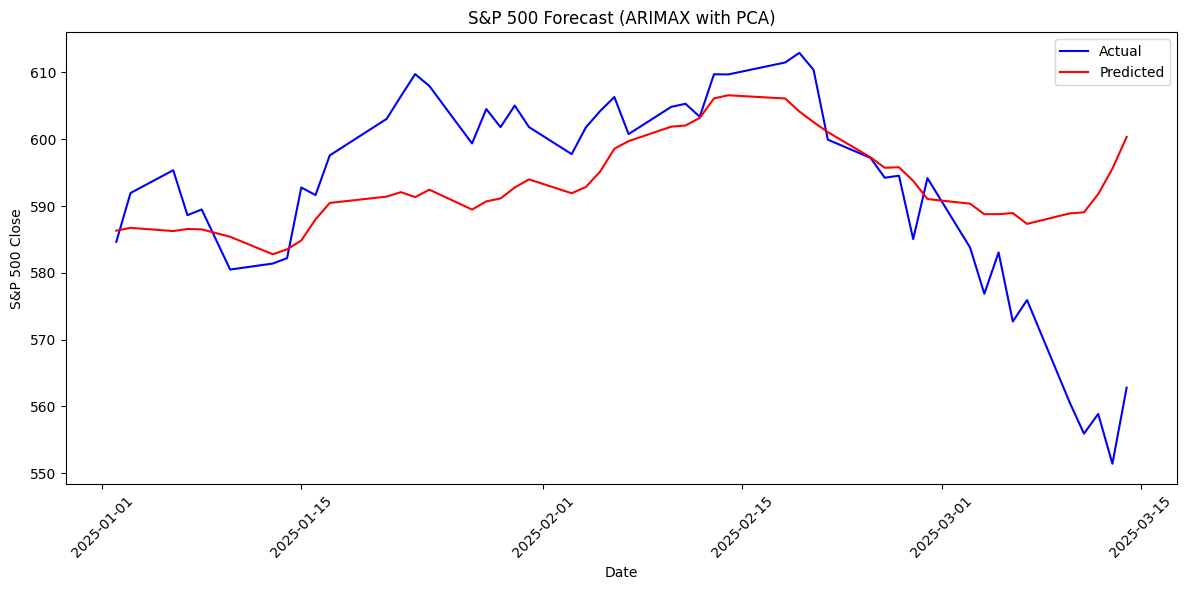

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

# Load datasets
data_path = "data"
file_names = {
    "bitcoin": "bitcoin.csv",
    "gold": "gold.csv",
    "google_trends": "google_trends.csv",
    "sp500": "sp500.csv",
    "treasury_3m": "treasury_3m.csv",
    "treasury_10y": "treasury_10y.csv",
    "copper": "copper.csv",
    "oil": "oil.csv",
    "unemployment": "unemployment.csv",
    "moex": "MOEX.csv",
    "sse": "SSE.csv",
    "stoxx": "STOXX_600.csv"
}

data = {}
for key, file in file_names.items():
    file_path = os.path.join(data_path, file)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        if "timestamp" not in df.columns:
            continue
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df.replace({'.': np.nan}, inplace=True)
        for col in df.columns:
            if col != "timestamp":
                df[col] = pd.to_numeric(df[col], errors='coerce')
        data[key] = df

# Rename columns (standardized)
rename_map = {
    "bitcoin": {"Close": "bitcoin_close", "Open": "bitcoin_open", "High": "bitcoin_high", "Low": "bitcoin_low", "Volume": "bitcoin_volume"},
    "gold": {"Close": "gold_close", "Open": "gold_open", "High": "gold_high", "Low": "gold_low", "Volume": "gold_volume"},
    "oil": {"Close": "oil_close", "Open": "oil_open", "High": "oil_high", "Low": "oil_low", "Volume": "oil_volume"},
    "copper": {"price": "copper_price"},
    "google_trends": {"SPX": "google_spx", "ETF": "google_etf", "index fund": "google_index_fund", "sp500": "google_sp500"},
    "unemployment": {"Unemployment": "unemployment_rate"},
    "treasury_3m": {"Close": "treasury_3m"},
    "treasury_10y": {"Close": "treasury_10y"},
    "sp500": {"Close": "sp500_close"},
    "moex": {"Close": "moex_close"},
    "sse": {"Close": "sse_close"},
    "stoxx": {"Close": "stoxx_close"}
}

for key, renames in rename_map.items():
    if key in data:
        data[key] = data[key].rename(columns=renames)

# Merge all datasets on timestamp
sp500 = data["sp500"]
all_data = sp500[["timestamp", "sp500_close"]]
for key, df in data.items():
    if key != "sp500":
        all_data = all_data.merge(df, on="timestamp", how="left")

# Clean and prepare
all_data.sort_values("timestamp", inplace=True)
all_data.fillna(method="ffill", inplace=True)
all_data.dropna(inplace=True)
all_data = all_data.loc[:, all_data.nunique() > 1]

# Define target and features
target = "sp500_close"
exclude_cols = ["timestamp", target]
exog_vars = [col for col in all_data.columns if col not in exclude_cols]

# Train/test split
split_date = pd.Timestamp("2025-01-01")
train = all_data[all_data["timestamp"] < split_date]
test = all_data[all_data["timestamp"] >= split_date]

y_train = train[target]
y_test = test[target]
X_train = train[exog_vars]
X_test = test[exog_vars]

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"PCA reduced features from {X_train.shape[1]} to {X_train_pca.shape[1]} components.")

# Auto ARIMA to select best order
print("Running auto_arima to select best (p,d,q)...")
auto_model = auto_arima(
    y_train,
    exogenous=X_train_pca,
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    d=None,
    seasonal=False,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    maxiter=500
)
order = auto_model.order
print(f"Best ARIMA order: {order}")

# Fit ARIMAX
model = SARIMAX(y_train, exog=X_train_pca, order=order,
                enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.forecast(steps=len(X_test_pca), exog=X_test_pca)

# PCA Component Impact on Prediction
pca_coefficients = model_fit.params[-X_train_pca.shape[1]:]

component_impact = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(X_train_pca.shape[1])],
    "Coefficient": pca_coefficients.values,
    "Abs Coefficient": np.abs(pca_coefficients.values),
    "Explained Variance Ratio": pca.explained_variance_ratio_
}).sort_values(by="Abs Coefficient", ascending=False)

print("\nPrincipal Component Impact on Prediction:")
print(component_impact.head(10))  # Top 10 most impactful components

# Evaluate
r2 = r2_score(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
mse = mean_squared_error(y_test, forecast)
rmse = np.sqrt(mse)

print("\nModel Evaluation:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"AIC: {model_fit.aic:.2f}")

# Save results
os.makedirs("results", exist_ok=True)
pred_df = pd.DataFrame({
    "timestamp": test["timestamp"].values,
    "actual": y_test.values,
    "predicted": forecast
})
pred_df.to_csv("results/ARIMAX_predictions_with_PCA.csv", index=False)
print("\n✅ Results saved to: results/ARIMAX_predictions_with_PCA.csv")

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(test["timestamp"], y_test, label="Actual", color='blue')
plt.plot(test["timestamp"], forecast, label="Predicted", color='red')
plt.title("S&P 500 Forecast (ARIMAX with PCA)")
plt.xlabel("Date")
plt.ylabel("S&P 500 Close")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
